In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import rnn
import ltc
import viz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
a = torch.randn(10)
b = torch.randn(10)
print(a,b)
print(torch.cat((a,b), dim=0))

tensor([ 1.6887,  0.2608, -0.4061, -0.0942, -1.8507, -1.6340,  0.1286, -1.4593,
        -0.7755, -0.5456]) tensor([ 0.9586, -0.2018, -1.8586, -0.9851, -0.6295, -0.8066,  0.0928,  0.4368,
         0.7998, -2.2931])
tensor([ 1.6887,  0.2608, -0.4061, -0.0942, -1.8507, -1.6340,  0.1286, -1.4593,
        -0.7755, -0.5456,  0.9586, -0.2018, -1.8586, -0.9851, -0.6295, -0.8066,
         0.0928,  0.4368,  0.7998, -2.2931])


In [3]:
train_data = pd.read_csv('DailyDelhiClimateTrain.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
features = train_data[['meantemp', 'humidity']]
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
X, y = rnn.create_sequences(features_scaled, seq_length=30)
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
X_train, y_train = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device)
X_val, y_val = torch.Tensor(X_val).to(device), torch.Tensor(y_val).to(device)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)


test_data = pd.read_csv('DailyDelhiClimateTest.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_features = test_data[['meantemp', 'humidity']]
test_features_scaled = scaler.transform(test_features)
X_test, y_test = rnn.create_sequences(test_features_scaled, seq_length=30)
X_test, y_test = torch.Tensor(X_test).to(device), torch.Tensor(y_test).to(device)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

In [4]:
results_dict = {}
model_name = []

In [ ]:
tau1 = 0.7
tau2 = 1.0
tau3 = 10.0
tau4 = 0.7
alpha = 0.005

In [5]:
ltc_1 = ltc.ParallelMultiScaleLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=tau1, tau2=tau2, tau3=tau3, tau4=tau4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_1.parameters(), lr=alpha)

ltc_1,ltc1_time,epoch_dx_dt_history = ltc.train_LTC_model(train_loader, val_loader, ltc_1, criterion, optimizer, device)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = ltc.evaluate_LTC_model(test_loader, ltc_1, device)
results = {'train_time': ltc1_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}

results_dict['ltc_parallel_1'] = results

viz.plot_results(predictions, actuals)

viz.plot_dx_dt_history(epoch_dx_dt_history)

Epoch 1/30, Training Loss: 28.6949, Validation Loss: 1.8114
Average dx/dt values for each layer: {'layer1': 0.1856260523200035, 'layer2': 0.0002677015194826203, 'layer3': 0.0028560842975922343, 'layer4': 0.1142585293079416}, Average dx/dt value across three layers: 0.0758
Epoch 2/30, Training Loss: 1.4341, Validation Loss: 0.9550
Average dx/dt values for each layer: {'layer1': 0.1720492576973306, 'layer2': 0.0002708429865379003, 'layer3': 0.0028251730481214407, 'layer4': 0.1168829414786564}, Average dx/dt value across three layers: 0.0730
Epoch 3/30, Training Loss: 0.8708, Validation Loss: 0.7160
Average dx/dt values for each layer: {'layer1': 0.16674670121735996, 'layer2': 0.00027280477075287816, 'layer3': 0.002814609282520703, 'layer4': 0.11545853772097164}, Average dx/dt value across three layers: 0.0713
Epoch 4/30, Training Loss: 0.6599, Validation Loss: 0.6793
Average dx/dt values for each layer: {'layer1': 0.16684309682912296, 'layer2': 0.00027367573642954487, 'layer3': 0.0028055

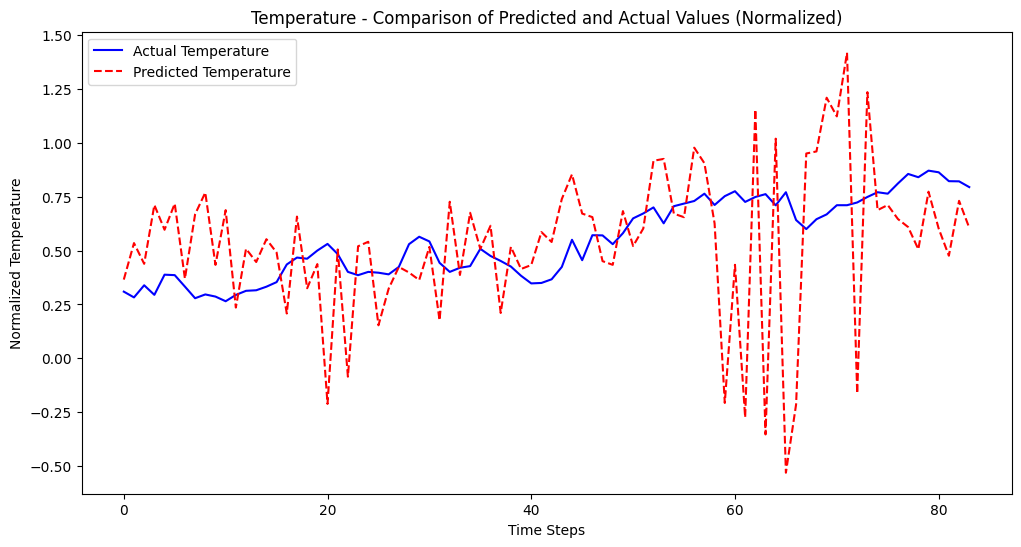

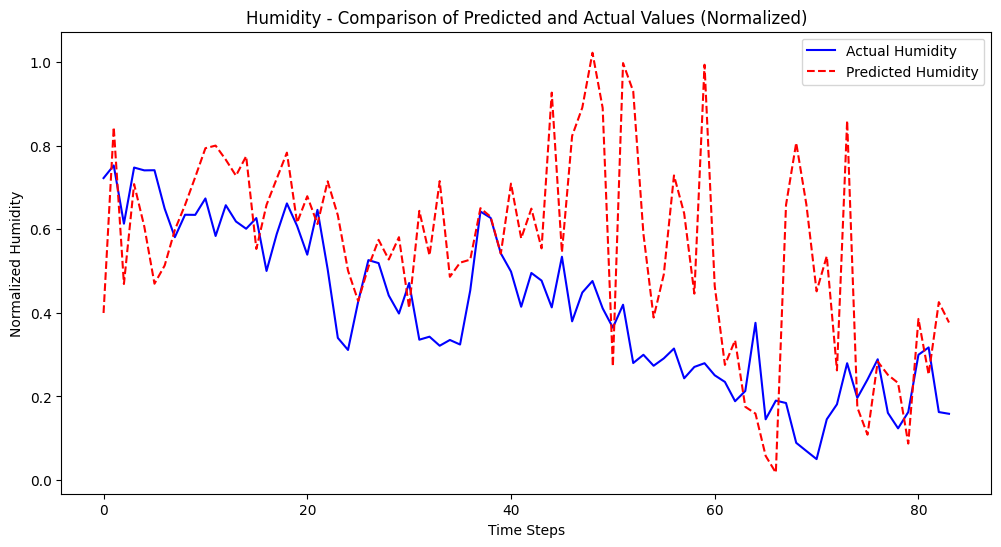

In [7]:
ltc_2 = ltc.ParallelMultiScaleLTCModel2(input_size=2, hidden_size=50, output_size=2,tau1=tau1, tau2=tau2, tau3=tau3, tau4=tau4).to(device)
current_ltc = ltc_2
criterion = nn.MSELoss()
optimizer = optim.Adam(current_ltc.parameters(), lr=alpha)

current_ltc,current_ltc_time,epoch_dx_dt_history = ltc.train_LTC_model(train_loader, val_loader, current_ltc, criterion, optimizer, device)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = ltc.evaluate_LTC_model(test_loader, current_ltc, device)
results = {'train_time': current_ltc_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_temp':mse_temp,'mse_humidity':mse_humidity, 'mase_temp':mase_temp, 'mase_humidity':mase_humidity}

results_dict['ltc_parallel_2'] = results

viz.plot_results(predictions, actuals)

viz.plot_dx_dt_history(epoch_dx_dt_history)